In [2]:
# import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,TensorDataset,Subset
import copy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-2-b7312e8d9eb1>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [3]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
Ts = T.Compose([ T.ToTensor(),
                 T.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
                   ])

In [5]:
# download the CIFAR10 dataset
train_data = torchvision.datasets.CIFAR10(root='cifar10',train=True , download=True, transform=Ts)
test_data = torchvision.datasets.CIFAR10(root='cifar10',train=False , download=True, transform=Ts)

100%|██████████| 170498071/170498071 [00:10<00:00, 15796719.40it/s]


Extracting cifar10/cifar-10-python.tar.gz to cifar10
Files already downloaded and verified


In [6]:
randinx=np.random.permutation(10000)
devset=Subset(test_data,randinx[:6000])
testset=Subset(test_data,randinx[6000:])

In [7]:
# check out the shape of the dataset
print( train_data.data.shape )

# the unique categories
print( train_data.classes )

# .targets is a list of targets converted to ints
print( len(train_data.targets) )

(50000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
50000


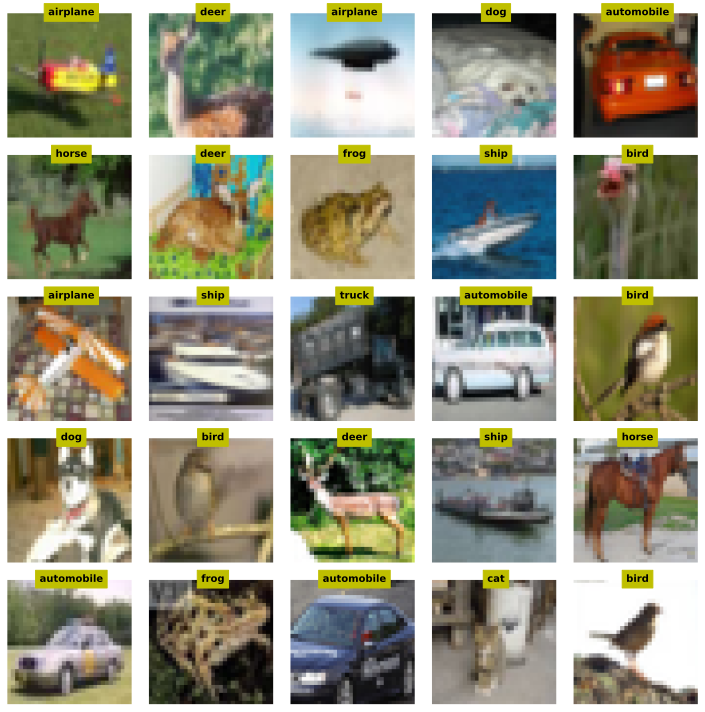

In [8]:
# inspect a few random images

fig,axs = plt.subplots(5,5,figsize=(10,10))

for ax in axs.flatten():

  # select a random picture
  randidx = np.random.choice(len(train_data.targets))

  # extract that image
  pic = train_data.data[randidx,:,:,:]
  # and its label
  label = train_data.classes[train_data.targets[randidx]]


  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
#  translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(testset,batch_size=len(testset))
dev_loader  = DataLoader(devset ,batch_size=len(devset))

In [ ]:
x,y=next(iter(train_loader))
x.data.shape

torch.Size([32, 3, 32, 32])

In [ ]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class cnnnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle


      # first convolution layer
      self.conv1  = nn.Conv2d(3,64,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(64)


      # second convolution layer
      self.conv2  = nn.Conv2d(64,64,3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(64)


      # third convolution layer
      self.conv3  = nn.Conv2d(64,128,3,padding=1)
      self.bnorm3 = nn.BatchNorm2d(128)


      # fourth convolution layer
      self.conv4  = nn.Conv2d(128,128,3,padding=1)
      self.bnorm4 = nn.BatchNorm2d(128)

      # fifth convolution layer
      self.conv5  = nn.Conv2d(128,128,3,padding=1)
      self.bnorm5 = nn.BatchNorm2d(128)



      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(1*1*128,128)
      self.fc2 = nn.Linear(128,64)
      self.fc3 = nn.Linear(64,50)
      self.fc4 = nn.Linear(50,10)


    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      x = F.dropout(x,p=.25,training=self.training)
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      x = F.dropout(x,p=.25,training=self.training)

      if self.print: print(f'Second CPR block: {list(x.shape)}')


      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x),2)
      x = F.leaky_relu(self.bnorm3(x))
      x = F.dropout(x,p=.25,training=self.training)

      if self.print: print(f'third CPR block: {list(x.shape)}')

      # fourth block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv4(x),2)
      x = F.leaky_relu(self.bnorm4(x))
      x = F.dropout(x,p=.25,training=self.training)

      if self.print: print(f'fourth CPR block: {list(x.shape)}')

      # fifth block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv5(x),2)
      x = F.leaky_relu(self.bnorm5(x))
      x = F.dropout(x,p=.25,training=self.training)

      if self.print: print(f'fifth CPR block: {list(x.shape)}')


      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.25,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=.25,training=self.training)
      x = F.leaky_relu(self.fc3(x))
      x = F.dropout(x,p=.25,training=self.training)

      x = self.fc4(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = cnnnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)

  return net,lossfun,optimizer

In [ ]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

Input: [32, 3, 32, 32]
First CPR block: [32, 64, 16, 16]
Second CPR block: [32, 64, 8, 8]
third CPR block: [32, 128, 4, 4]
fourth CPR block: [32, 128, 2, 2]
fifth CPR block: [32, 128, 1, 1]
Vectorized: [32, 128]
Final output: [32, 10]

Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.2983, grad_fn=<NllLossBackward0>)


In [ ]:
# a function that trains the model

def funtion2trainTheModel():

  # number of epochs
  numepochs = 80

  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss   = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc    = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)


    #### test performance
    net.eval() # switch to test mode
    batchAcc  = []
    batchLoss = []
    for X,y in dev_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat,y)

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    devLoss[epochi] = np.mean(batchLoss)
    devAcc[epochi]  = 100*np.mean(batchAcc)
    print(f'Finished epoch {epochi+1}/{numepochs}. devAcc = {devAcc[epochi]:.2f}%')


  # end epochs

  # function output
  return trainLoss,devLoss,trainAcc,devAcc,net

In [ ]:

trainLoss,devLoss,trainAcc,devAcc,net = funtion2trainTheModel()

Finished epoch 1/80. devAcc = 54.65%
Finished epoch 2/80. devAcc = 64.17%
Finished epoch 3/80. devAcc = 69.65%
Finished epoch 4/80. devAcc = 71.83%
Finished epoch 5/80. devAcc = 72.82%
Finished epoch 6/80. devAcc = 74.43%
Finished epoch 7/80. devAcc = 74.50%
Finished epoch 8/80. devAcc = 73.87%
Finished epoch 9/80. devAcc = 76.73%
Finished epoch 10/80. devAcc = 78.23%
Finished epoch 11/80. devAcc = 77.38%
Finished epoch 12/80. devAcc = 78.63%
Finished epoch 13/80. devAcc = 78.73%
Finished epoch 14/80. devAcc = 79.32%
Finished epoch 15/80. devAcc = 79.70%
Finished epoch 16/80. devAcc = 79.97%
Finished epoch 17/80. devAcc = 79.57%
Finished epoch 18/80. devAcc = 80.67%
Finished epoch 19/80. devAcc = 80.32%
Finished epoch 20/80. devAcc = 80.22%
Finished epoch 21/80. devAcc = 80.77%
Finished epoch 22/80. devAcc = 80.97%
Finished epoch 23/80. devAcc = 80.95%
Finished epoch 24/80. devAcc = 81.03%
Finished epoch 25/80. devAcc = 80.82%
Finished epoch 26/80. devAcc = 80.30%
Finished epoch 27/80.

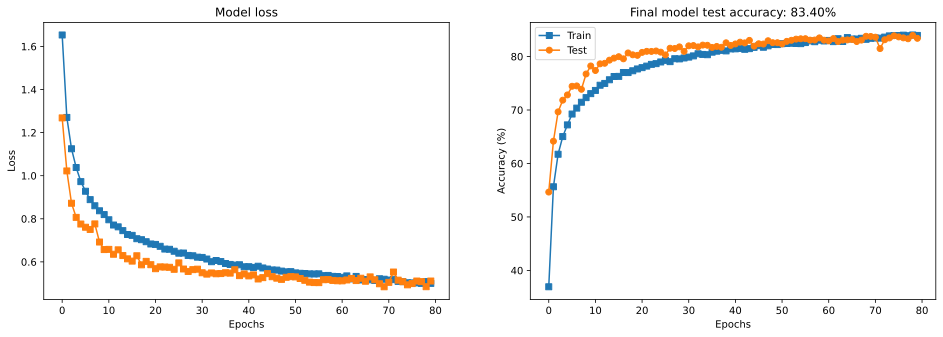

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'s-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {devAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
#devAccs = []
devAccs.append(devAcc[-1])
devAccs

[tensor(80.2500),
 tensor(83.2667),
 tensor(83.2667),
 tensor(82.5833),
 tensor(83.4000)]

In [ ]:
## the real test set!

net.eval() # switch to test mode
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLoss = loss.item()
testAcc  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

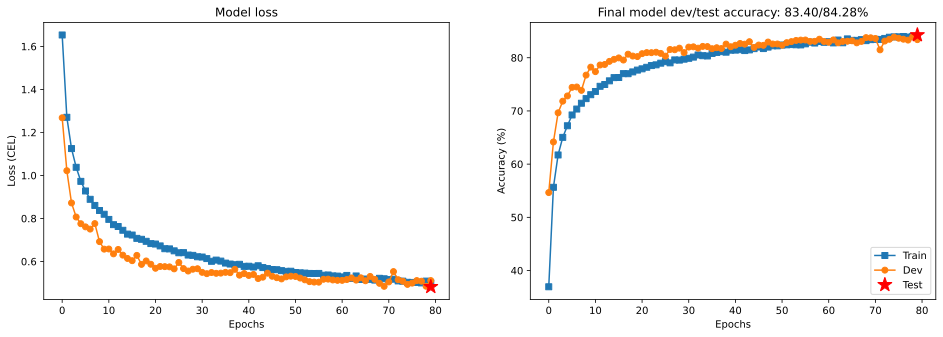

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].plot(len(devLoss)-1,testLoss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot(len(devAcc)-1,testAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].legend()

plt.show()

#  Transfer learning using vgg16

In [ ]:
#Import and inspect the vgg model
vggnet = torchvision.models.vgg16(pretrained=True)
from torchsummary import summary
summary(vggnet.to(device),(3,32,32))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [ ]:
# Freeze all layers
for p in vggnet.parameters():
    p.requires_grad = False

In [ ]:
# change the final layer
vggnet.classifier[6] = nn.Linear(vggnet.classifier[6].in_features,10)

In [ ]:
# push the model to the GPU (if using)
vggnet.to(device);

In [ ]:
lossfun = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(vggnet.parameters(),lr=.001,weight_decay=1e-5)

In [ ]:
numepochs = 10

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over training data batches
  vggnet.train() # switch to train mode
  batchLoss = []
  batchAcc  = []
  for X,y in train_loader:

    # push data to GPU
#    X = X.to(device)
#    y = y.to(device)

    # forward pass and loss
    yHat = vggnet(X)
    loss = lossfun(yHat,y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  trainLoss[epochi] = np.mean(batchLoss)
  trainAcc[epochi]  = 100*np.mean(batchAcc)


  #### test performance (here done in batches!)
  vggnet.eval() # switch to test mode
  batchAcc  = []
  batchLoss = []
  for X,y in test_loader:

    # push data to GPU
#    X = X.to(device)
#    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = vggnet(X)
      loss = lossfun(yHat,y)

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  testLoss[epochi] = np.mean(batchLoss)
  testAcc[epochi]  = 100*np.mean(batchAcc)

  # print out a status update
  print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')

Finished epoch 1/10. Test accuracy = 58.05%
Finished epoch 2/10. Test accuracy = 59.18%
Finished epoch 3/10. Test accuracy = 60.78%
Finished epoch 4/10. Test accuracy = 57.65%
Finished epoch 5/10. Test accuracy = 60.60%
Finished epoch 6/10. Test accuracy = 60.08%
Finished epoch 7/10. Test accuracy = 59.22%
Finished epoch 8/10. Test accuracy = 58.62%
Finished epoch 9/10. Test accuracy = 58.95%
Finished epoch 10/10. Test accuracy = 60.80%


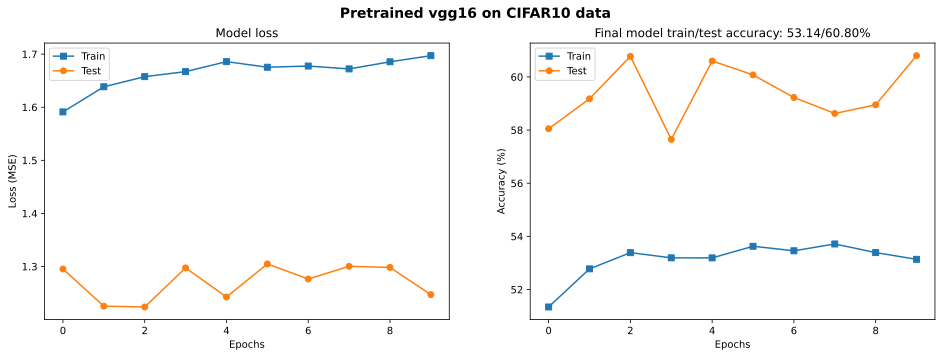

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained vgg16 on CIFAR10 data',fontweight='bold',fontsize=14)
plt.show()

# **Autoencoder**

In [18]:
# create a class for the model
def makeTheAENet(printtoggle=False):

  class aenet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- encoding layers -------------- ###
      # first convolution layer
      self.encconv1  = nn.Conv2d(3,16,4,padding=1,stride=2) # note: using stride instead of pool to downsample
      # output size: (32+2*1-)4/2 + 1 = 16
      self.bnorm1 = nn.BatchNorm2d(16)




      # second convolution layer
      self.encconv2  = nn.Conv2d(16,32,4,padding=1,stride=2)
      # output size: (16+2*1-4)/2 + 1 = 8
      self.bnorm2 = nn.BatchNorm2d(32)



      # fifth convolution layer (latent code layer)
      self.latent  = nn.Conv2d(32,64,4,padding=1,stride=2)
      # output size: (8+2*1-4)/2 + 1 = 4
      self.bnorm3 = nn.BatchNorm2d(64)



      ### -------------- decoding layers -------------- ###

      # first convolution layer
      self.decconv1  = nn.ConvTranspose2d(64,32,4,padding=1,stride=2)


      # fourth convolution layer
      self.decconv4  = nn.ConvTranspose2d(32,16,4,padding=1,stride=2)

      # fifth convolution layer (output)
      self.output  = nn.ConvTranspose2d(16,3,4,padding=1,stride=2)


    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first encoder layer

      x = F.leaky_relu(self.bnorm1(self.encconv1(x)))
      if self.print: print(f'First encoder block: {list(x.shape)}')

      # second encoder layer
      x = F.leaky_relu(self.bnorm2(self.encconv2(x)))
      if self.print: print(f'Second encoder block: {list(x.shape)}')


      # latent layer
      x = F.leaky_relu( self.latent(x) )
      if self.print: print(f'Third encoder block: {list(x.shape)}')




      # first decoder block
      x = F.leaky_relu( self.decconv1(x) )
      if self.print: print(f'First decoder block: {list(x.shape)}')


      # fourth decoder block
      x = F.leaky_relu( self.decconv4(x) )
      if self.print: print(f' fourth decoder block: {list(x.shape)}')

      #  fifth decoder block (output)
      x = F.leaky_relu( self.output(x) )
      if self.print: print(f'Decoder output: {list(x.shape)}')

      return x

  # create the model instance
  net = aenet(printtoggle)

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)

  return net,lossfun,optimizer


In [19]:
# test the model with one batch
aenet,lossfun,optimizer = makeTheAENet(True)

X,y = next(iter(train_loader))
yHat = aenet(X)

# now compute the loss
loss = lossfun(yHat,X)
print(' ')
print('Loss:')
print(loss)

Input: [32, 3, 32, 32]
First encoder block: [32, 16, 16, 16]
Second encoder block: [32, 32, 8, 8]
Third encoder block: [32, 64, 4, 4]
First decoder block: [32, 32, 8, 8]
 fourth decoder block: [32, 16, 16, 16]
Decoder output: [32, 3, 32, 32]
 
Loss:
tensor(0.2463, grad_fn=<MseLossBackward0>)


In [26]:
# a function that trains the model

def funtion2trainTheAEModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 100

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []

    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)


    #### test performance (here done in batches!)
    net.eval() # switch to test mode
    batchLoss = []

    for X,y in test_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      with torch.no_grad():
        yHat = net(X)
        loss = lossfun(yHat,X)

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    testLoss[epochi] = np.mean(batchLoss)
    print(f'Finished epoch {epochi+1}/{numepochs}. Test loss = {testLoss[epochi]:.4f}%')
  # end epochs
   #print out a status update

  # function output
  return trainLoss,testLoss,net

In [21]:
# create a new model (comment out to re-train)
netAE,lossfun,optimizer = makeTheAENet()

trainLossAE,testLossAE,netAE = funtion2trainTheAEModel(netAE,lossfun,optimizer)

Finished epoch 1/100. Test loss = 0.04%
Finished epoch 2/100. Test loss = 0.03%
Finished epoch 3/100. Test loss = 0.02%
Finished epoch 4/100. Test loss = 0.02%
Finished epoch 5/100. Test loss = 0.02%
Finished epoch 6/100. Test loss = 0.02%
Finished epoch 7/100. Test loss = 0.02%
Finished epoch 8/100. Test loss = 0.02%
Finished epoch 9/100. Test loss = 0.02%
Finished epoch 10/100. Test loss = 0.02%
Finished epoch 11/100. Test loss = 0.01%
Finished epoch 12/100. Test loss = 0.01%
Finished epoch 13/100. Test loss = 0.01%
Finished epoch 14/100. Test loss = 0.01%
Finished epoch 15/100. Test loss = 0.01%
Finished epoch 16/100. Test loss = 0.01%
Finished epoch 17/100. Test loss = 0.01%
Finished epoch 18/100. Test loss = 0.01%
Finished epoch 19/100. Test loss = 0.01%
Finished epoch 20/100. Test loss = 0.01%
Finished epoch 21/100. Test loss = 0.01%
Finished epoch 22/100. Test loss = 0.01%
Finished epoch 23/100. Test loss = 0.01%
Finished epoch 24/100. Test loss = 0.01%
Finished epoch 25/100. Te

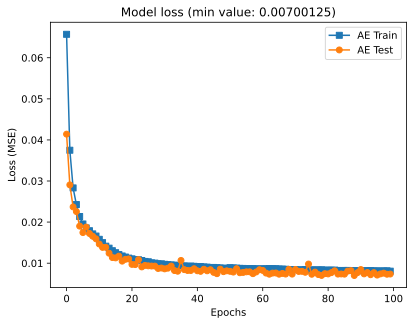

In [25]:
plt.plot(trainLossAE,'s-',label='AE Train')
plt.plot(testLossAE,'o-',label='AE Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (min value: %g)'%min(testLossAE))
plt.legend()

plt.show()

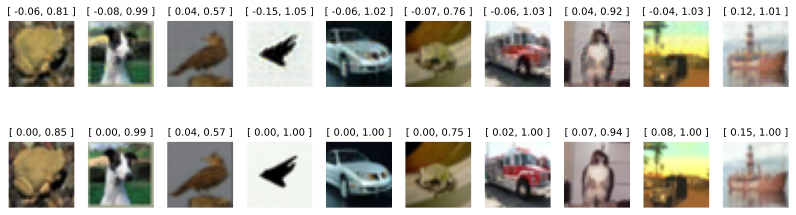

In [27]:

# get some data
X,y = next(iter(test_loader))

# forward pass and loss
netAE.cpu()
netAE.eval() # switch to test mode
yHat = netAE(X)


fig,axs = plt.subplots(2,10,figsize=(14,4))

for i in range(10):
  pic = yHat[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[0,i].imshow(pic)
  axs[0,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[0,i].axis('off')

  pic = X[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[1,i].imshow(pic)
  axs[1,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[1,i].axis('off')


plt.show()

In [28]:
#save the model
torch.save(netAE.state_dict(),'trainedAE_model.pt')